### Nous allons mettre en place les pipelines de classification sur les données obtenues en concatenant les articles de la phase 2 avec ceux de la phase 1 (clean_text: noms de maladie supprimés, textes incompréhensibles supprimés)

Les données que nous chargeons ici ont déjà été prétraitées dans le notebook *rassemblage_data.ipynb*:

- Suppression des caractères spéciaux
- Suppresion des mots vides : comme nous allons faire la classification avec naive bayes ici c'est necessaire 
- Suppression des espaces multiples 
- Normalisation supplémentaire: mise en minuscules; suppression de la ponctuation; suppression des espaces inutiles , lemmatisation



### Nous allons utiliser les indexes que nous avons crées afin de rendre reproductible les différents sous-ensembles pour des comparaisons équitables entre les approches  

In [1]:
import pandas as pd 

#   Les données formées à partir des données nettoyées de la phase 1 et celle de la phase 2
data = pd.read_csv("./data/data_final_phase2_private.csv", keep_default_na=False)


data.head()

,text,tokens_clean,text_clean,type_article,thematique
0,Microbial Community Composition Associated wit...,"['microbial', 'community', 'composition', 'ass...",microbial community composition associated pot...,VS,SV
1,Plant Pathogenic and Endophytic Colletotrichum...,"['plant', 'pathogenic', 'endophytic', 'colleto...",plant pathogenic endophytic colletotrichum fru...,VS,SV
2,Lethal Bronzing: What you should know about th...,"['lethal', 'bronzing', 'know', 'disease', 'tur...",lethal bronzing know disease turn palm tree br...,VS,SV
3,Leaffooted Bug Damage in Almond Orchards Leaff...,"['leaffooted', 'bug', 'damage', 'almond', 'orc...",leaffooted bug damage almond orchard leaffoote...,VS,SV
4,Kebbi govt battles mysterious disease affectin...,"['kebbi', 'govt', 'battle', 'mysterious', 'dis...",kebbi govt battle mysterious disease affecting...,VS,SV


In [3]:
data["thematique"].value_counts()

thematique
SV    1422
SA    1068
Name: count, dtype: int64

In [4]:
data["type_article"].value_counts()

type_article
NVS    2241
VS      249
Name: count, dtype: int64

### Visualisons le word_cloud ainsi que la courbe de la loi zip de nos tokens_nettoyes

In [11]:
import ast 

# Conversion de la chaîne vers liste Python réelle
data["tokens_clean"] = data["tokens_clean"].apply(ast.literal_eval)

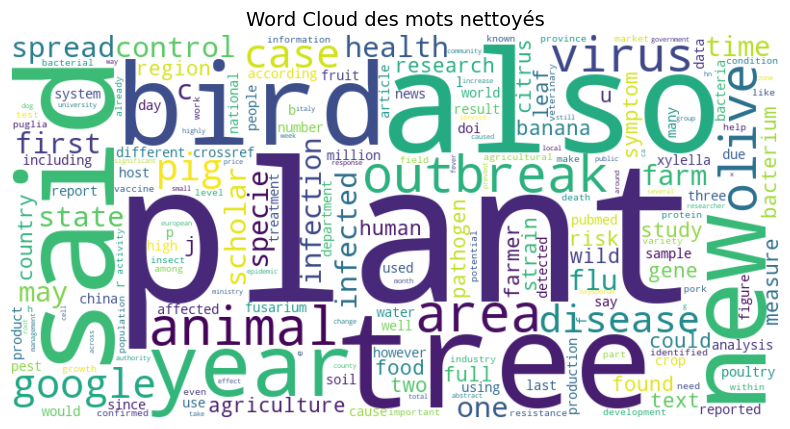

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Fusionnons tous les tokens dans une liste 

all_tokens = [token for tokens in data["tokens_clean"] for token in tokens]

# Calcul de la fréquence des mots 
token_counts = Counter(all_tokens)

# Affichage du word_cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200
).generate_from_frequencies(token_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud des mots nettoyés", fontsize=14)
plt.show()


### Nous allons commencer une première classification de ces textes nettoyés avec naive bayes, nous allons faire une vectorisation avec tidf de ces textes


=== Rapport de classification (TEST) — TF-IDF + MultinomialNB ===
              precision    recall  f1-score   support

         NVS       0.92      1.00      0.96       202
          VS       1.00      0.22      0.36        23

    accuracy                           0.92       225
   macro avg       0.96      0.61      0.66       225
weighted avg       0.93      0.92      0.90       225



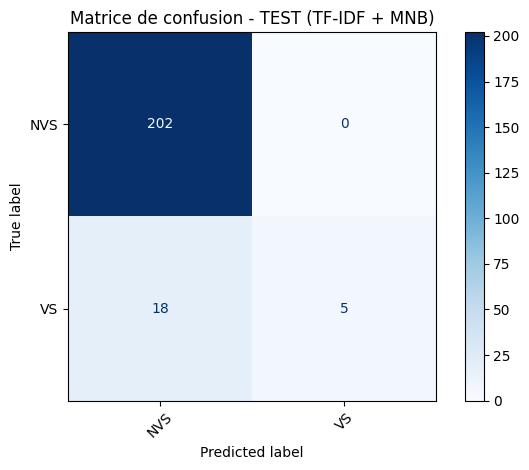


=== Erreurs par thématique (TEST) ===
            Total  Erreurs  Erreur (%)
thematique                            
SV            120       10    8.333333
SA            105        8    7.619048

Fichiers sauvegardés dans models_nb/


In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt

# ===== 1) Charger les index sauvegardés =====
idx_train = np.load("splits_idx_train.npy")
idx_test  = np.load("splits_idx_test.npy")

# ===== 2) Données =====
X_all = data["text_clean"].astype(str).to_numpy()
y_all = data["type_article"].to_numpy()


X_train_texts, X_test_texts = X_all[idx_train],  X_all[idx_test]
y_train,  y_test      = y_all[idx_train],  y_all[idx_test]

# ===== 3) TF-IDF (fit sur TRAIN uniquement) =====
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train_texts)
X_test_vec  = vectorizer.transform(X_test_texts)

# ===== 4) Naive Bayes =====
clf = MultinomialNB()
clf.fit(X_train_vec, y_train)

# ===== 5) Prédictions TEST =====
y_pred = clf.predict(X_test_vec)
y_prob = clf.predict_proba(X_test_vec) if hasattr(clf, "predict_proba") else None

# ===== 6) Rapport global =====
print("\n=== Rapport de classification (TEST) — TF-IDF + MultinomialNB ===")
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_all))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_all))
disp.plot(cmap="Blues")
plt.title("Matrice de confusion - TEST (TF-IDF + MNB)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ===== 7) Erreurs par thématique =====
thematique_test = data.iloc[idx_test]["thematique"].reset_index(drop=True)

df_test = pd.DataFrame({
    "true_type": pd.Series(y_test).reset_index(drop=True),
    "pred_type": pd.Series(y_pred),
    "thematique": thematique_test
})
df_test["erreur"] = df_test["true_type"] != df_test["pred_type"]

erreurs_par_theme = df_test.groupby("thematique").agg(
    Total=("erreur", "count"),
    Erreurs=("erreur", "sum")
)
erreurs_par_theme["Erreur (%)"] = erreurs_par_theme["Erreurs"] / erreurs_par_theme["Total"] * 100
print("\n=== Erreurs par thématique (TEST) ===")
print(erreurs_par_theme.sort_values("Erreur (%)", ascending=False))

# ===== 8) Sauvegardes =====
import os
os.makedirs("models_nb", exist_ok=True)
joblib.dump(vectorizer, "models_nb/tfidf.pkl")
joblib.dump(clf, "models_nb/naive_bayes.pkl")
df_test.to_csv("models_nb/test_predictions.csv", index=False)
erreurs_par_theme.to_csv("models_nb/erreurs_par_thematique.csv", index=False)
print("\nFichiers sauvegardés dans models_nb/")


### Essayons de calculer l'AUC-PR et d'afficher la courbe 

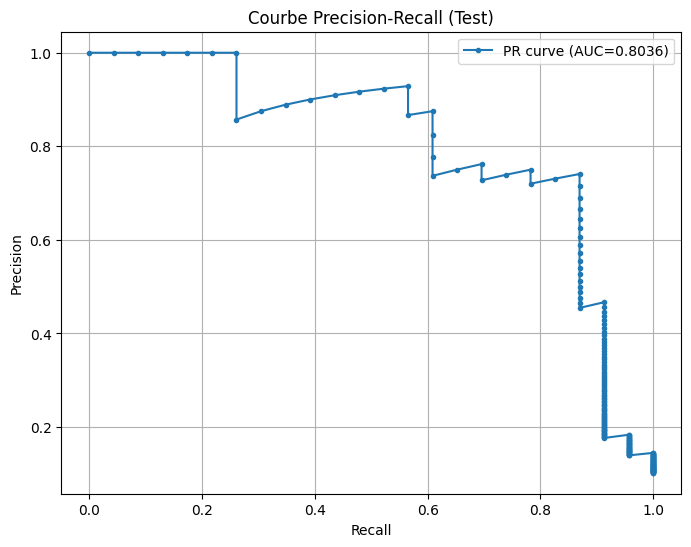

In [17]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    average_precision_score
)
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

# === 1. Prédictions probabilistes ===
y_scores = clf.predict_proba(X_test_vec)

# === 2. Encodage binaire des classes ===
# On suppose que "VS" est la classe positive (à adapter selon ton besoin)
positive_class = "VS"
lb = LabelBinarizer(pos_label=1, neg_label=0)
y_test_bin = lb.fit_transform(y_test)
positive_index = list(clf.classes_).index(positive_class)

# === 3. Courbe Precision-Recall ===
precision, recall, thresholds = precision_recall_curve(y_test_bin, y_scores[:, positive_index])
auc_pr = average_precision_score(y_test_bin, y_scores[:, positive_index])

# === 4. Affichage ===
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'PR curve (AUC={auc_pr:.4f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Courbe Precision-Recall (Test)")
plt.grid(True)
plt.legend()
plt.show()


Un point de cette courbe correspond à une évaluation sur tous les articles de l'ensemble de test à un seuil donné. Et le nombre de points dans la courbe dépend des seuils retournés dans la liste des scores de prédiction. Si ces scores sont très différents les uns des autres alors c'est possible qu'on ait beaucoup de points dans la courbe, mais ce nombre est au maximum le nombre d'éléments dans la matrice X_test_vec 

### Appliquons la regression logistique sur les données vectorisées avec TF-IDF 


=== Rapport de classification (TEST) — TF-IDF + LogisticRegression ===
              precision    recall  f1-score   support

         NVS       0.92      1.00      0.96       202
          VS       1.00      0.26      0.41        23

    accuracy                           0.92       225
   macro avg       0.96      0.63      0.69       225
weighted avg       0.93      0.92      0.90       225



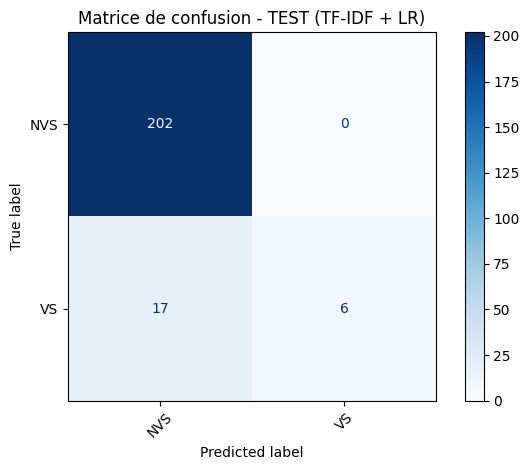


=== Erreurs par thématique (TEST) ===
            Total  Erreurs  Erreur (%)
thematique                            
SV            120       10    8.333333
SA            105        7    6.666667

Fichiers sauvegardés dans models_lr/


In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
import os

# ===== 1) Charger les index sauvegardés =====
idx_train = np.load("splits_idx_train.npy")  
idx_test  = np.load("splits_idx_test.npy")

# ===== 2) Données =====
X_all = data["text_clean"].astype(str).to_numpy()
y_all = data["type_article"].to_numpy()

X_train_texts, X_test_texts = X_all[idx_train], X_all[idx_test]
y_train, y_test = y_all[idx_train], y_all[idx_test]

# ===== 3) TF-IDF (fit sur TRAIN uniquement) =====
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train_texts)
X_test_vec  = vectorizer.transform(X_test_texts)

# ===== 4) Régression Logistique =====
# class_weight='balanced' peut aider si fort déséquilibre ; à activer si besoin
clf = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
clf.fit(X_train_vec, y_train)

# ===== 5) Prédictions TEST =====
y_pred = clf.predict(X_test_vec)
y_prob = clf.predict_proba(X_test_vec) if hasattr(clf, "predict_proba") else None

# ===== 6) Rapport global =====
print("\n=== Rapport de classification (TEST) — TF-IDF + LogisticRegression ===")
print(classification_report(y_test, y_pred))

# (Optionnel) Matrice de confusion
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_all))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_all))
disp.plot(cmap="Blues")
plt.title("Matrice de confusion - TEST (TF-IDF + LR)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ===== 7) Erreurs par thématique =====
thematique_test = data.iloc[idx_test]["thematique"].reset_index(drop=True)

df_test = pd.DataFrame({
    "true_type": pd.Series(y_test).reset_index(drop=True),
    "pred_type": pd.Series(y_pred),
    "thematique": thematique_test
})
df_test["erreur"] = df_test["true_type"] != df_test["pred_type"]

erreurs_par_theme = df_test.groupby("thematique").agg(
    Total=("erreur", "count"),
    Erreurs=("erreur", "sum")
)
erreurs_par_theme["Erreur (%)"] = erreurs_par_theme["Erreurs"] / erreurs_par_theme["Total"] * 100
print("\n=== Erreurs par thématique (TEST) ===")
print(erreurs_par_theme.sort_values("Erreur (%)", ascending=False))

# ===== 8) Sauvegardes =====
os.makedirs("models_lr", exist_ok=True)
joblib.dump(vectorizer, "models_lr/tfidf.pkl")
joblib.dump(clf, "models_lr/logreg.pkl")
df_test.to_csv("models_lr/test_predictions.csv", index=False)
erreurs_par_theme.to_csv("models_lr/erreurs_par_thematique.csv")
print("\nFichiers sauvegardés dans models_lr/")


### Nous allons ici faire la classification par type en se servant uniquement des articles de l'une des thématiques à la fois puis nous ferons les tests avec les articles de l'autre thématique sur le modèle construit avec les articles de la thématique courante

L'objectif étant de tester la capacité de généralisation d’un modèle de classification d’articles par type (VS/NVS) lorsqu’il est entraîné sur une seule thématique (SA ou SV) et testé sur l’autre.

Cette expérimentation est juste pour voir le rapprochement qu'il peut avoir entre les deux thématiques, nous n'avons pas utilisé les indexes sauvegardés ici, car la séparation se fait déjà par thématique

In [21]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB  
from sklearn.metrics import classification_report


# 1. Filtrer les deux thématiques
df_sa = data[data["thematique"] == "SA"].copy()
df_sv = data[data["thematique"] == "SV"].copy()


# 3. Créer les étiquettes binaires pour VS/NVS
df_sa["label"] = df_sa["type_article"].map({"VS": 1, "NVS": 0})
df_sv["label"] = df_sv["type_article"].map({"VS": 1, "NVS": 0})

# 4. Définir les jeux d'entraînement et de test
X_train_sa, y_train_sa = df_sa["text_clean"], df_sa["label"]
X_test_sv, y_test_sv = df_sv["text_clean"], df_sv["label"]

X_train_sv, y_train_sv = df_sv["text_clean"], df_sv["label"]
X_test_sa, y_test_sa = df_sa["text_clean"], df_sa["label"]

# 5. Vectorisation
vectorizer = TfidfVectorizer(max_features=5000)
X_train_sa_vec = vectorizer.fit_transform(X_train_sa)
X_test_sv_vec = vectorizer.transform(X_test_sv)

X_train_sv_vec = vectorizer.fit_transform(X_train_sv)
X_test_sa_vec = vectorizer.transform(X_test_sa)

# 6. Modèle
model = MultinomialNB()

# ==== Cas 1 : entraînement sur SA, test sur SV ====
model.fit(X_train_sa_vec, y_train_sa)
y_pred_sv = model.predict(X_test_sv_vec)

print("Classification Report TF-IDF + Naive Bayes  :")

print("=== Évaluation : entraîné sur SA, testé sur SV ===")
print(classification_report(y_test_sv, y_pred_sv))

# ==== Cas 2 : entraînement sur SV, test sur SA ====
model.fit(X_train_sv_vec, y_train_sv)
y_pred_sa = model.predict(X_test_sa_vec)

print("=== Évaluation : entraîné sur SV, testé sur SA ===")
print(classification_report(y_test_sa, y_pred_sa))


Classification Report TF-IDF + Naive Bayes  :
=== Évaluation : entraîné sur SA, testé sur SV ===
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1326
           1       0.47      0.07      0.13        96

    accuracy                           0.93      1422
   macro avg       0.70      0.53      0.55      1422
weighted avg       0.91      0.93      0.91      1422

=== Évaluation : entraîné sur SV, testé sur SA ===
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       915
           1       0.00      0.00      0.00       153

    accuracy                           0.86      1068
   macro avg       0.43      0.50      0.46      1068
weighted avg       0.73      0.86      0.79      1068



d:\Rosalie\Classification_2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Rosalie\Classification_2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Rosalie\Classification_2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### commentaire:

On se rend compte que lorsqu'on prend l'ensemble des articles de SA comme train et on test sur SV (avec ce classifieur) les performances sont mieux que l'inverse 

In [17]:
print("Répartition SA :", df_sa["type_article"].value_counts())
print("Répartition SV :", df_sv["type_article"].value_counts())


Répartition SA : type_article
NVS    915
VS     153
Name: count, dtype: int64
Répartition SV : type_article
NVS    1326
VS       96
Name: count, dtype: int64


### Appliquons le classifieur Regression Logistique sur les textes vectorisés avec TF-IDF : données séparées par thématique 

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# 1. Séparer SA et SV
data_sa = data[data["thematique"] == "SA"].copy()
data_sv = data[data["thematique"] == "SV"].copy()


# 3. Labels
label_map = {"VS": 1, "NVS": 0}
data_sa["label"] = data_sa["type_article"].map(label_map)
data_sv["label"] = data_sv["type_article"].map(label_map)

# 4. Modèle
model = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
vectorizer = TfidfVectorizer(max_features=5000)

# === Cas 1 : Entraînement sur SA, test sur SV ===
X_train_sa = vectorizer.fit_transform(data_sa["text_clean"])
y_train_sa = data_sa["label"]

X_test_sv = vectorizer.transform(data_sv["text_clean"])
y_test_sv = data_sv["label"]

model.fit(X_train_sa, y_train_sa)
y_pred_sv = model.predict(X_test_sv)

print("Classification Report TF-IDF + RL :")

print("=== Évaluation : Entraîné sur SA, testé sur SV ===")
print(classification_report(y_test_sv, y_pred_sv, digits=3))
print(confusion_matrix(y_test_sv, y_pred_sv))

# === Cas 2 : Entraînement sur SV, test sur SA ===
vectorizer = TfidfVectorizer(max_features=5000)
X_train_sv = vectorizer.fit_transform(data_sv["text_clean"])
y_train_sv = data_sv["label"]

X_test_sa = vectorizer.transform(data_sa["text_clean"])
y_test_sa = data_sa["label"]

model = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
model.fit(X_train_sv, y_train_sv)
y_pred_sa = model.predict(X_test_sa)


print("\n=== Évaluation : Entraîné sur SV, testé sur SA ===")
print(classification_report(y_test_sa, y_pred_sa, digits=3))
print(confusion_matrix(y_test_sa, y_pred_sa))


Classification Report TF-IDF + RL :
=== Évaluation : Entraîné sur SA, testé sur SV ===
              precision    recall  f1-score   support

           0      0.963     0.956     0.959      1326
           1      0.449     0.500     0.473        96

    accuracy                          0.925      1422
   macro avg      0.706     0.728     0.716      1422
weighted avg      0.929     0.925     0.927      1422

[[1267   59]
 [  48   48]]

=== Évaluation : Entraîné sur SV, testé sur SA ===
              precision    recall  f1-score   support

           0      0.957     0.951     0.954       915
           1      0.717     0.745     0.731       153

    accuracy                          0.921      1068
   macro avg      0.837     0.848     0.842      1068
weighted avg      0.923     0.921     0.922      1068

[[870  45]
 [ 39 114]]


### Commentaire

La remarque faite au classifieur précédent est l'inverse ici mais le rappel dans la deuxième approche (train sur SV et test sur SA) est plus pertinent 

### Calculons l'AUC-PR et affichons les courbes pour toutes les approches évoquées plus haut sur les données séparées par thématique 

- train: SA; test: SV; classifieur NB
- train: SA; test: SV; classifieur RL
- train: SV; test: SA; classifieur NB
- train: SV; test: SA; classifieur RL 

In [24]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt


In [25]:
def plot_pr_curve(y_true, y_scores, label, color):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    auc_pr = average_precision_score(y_true, y_scores)
    plt.plot(recall, precision, label=f"{label} (AUC-PR={auc_pr:.3f})", color=color)


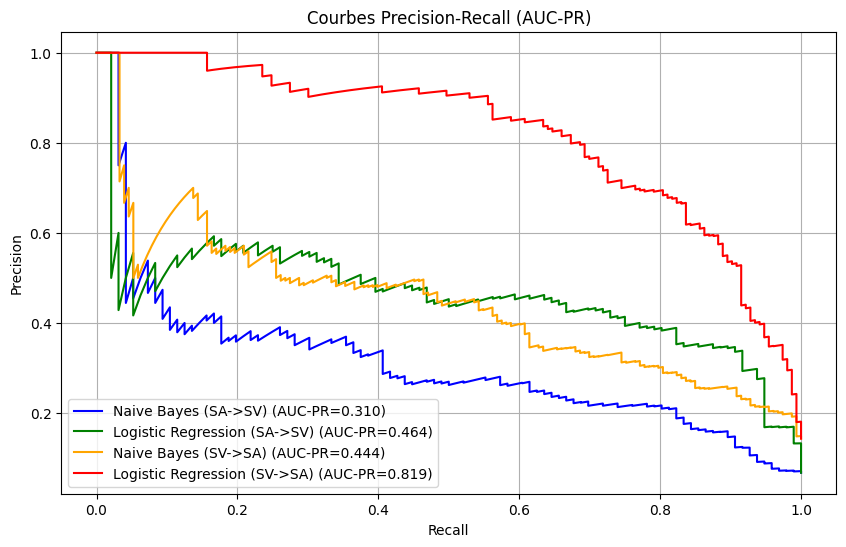

In [30]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

# === Données ===
data_sa = data[data["thematique"] == "SA"].copy()
data_sv = data[data["thematique"] == "SV"].copy()


label_map = {"VS": 1, "NVS": 0}
data_sa["label"] = data_sa["type_article"].map(label_map)
data_sv["label"] = data_sv["type_article"].map(label_map)

# === TF-IDF ===
vectorizer = TfidfVectorizer(max_features=5000)
X_train_sa = vectorizer.fit_transform(data_sa["text_clean"])
y_train_sa = data_sa["label"]
X_test_sv = vectorizer.transform(data_sv["text_clean"])
y_test_sv = data_sv["label"]

X_train_sv = vectorizer.fit_transform(data_sv["text_clean"])
y_train_sv = data_sv["label"]
X_test_sa = vectorizer.transform(data_sa["text_clean"])
y_test_sa = data_sa["label"]

# === Modèles ===
nb = MultinomialNB()
lr = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)

# === Entraîné sur SA, testé sur SV ===
nb.fit(X_train_sa, y_train_sa)
lr.fit(X_train_sa, y_train_sa)
nb_probs_sv = nb.predict_proba(X_test_sv)[:, 1]
lr_probs_sv = lr.predict_proba(X_test_sv)[:, 1]

# === Entraîné sur SV, testé sur SA ===
nb.fit(X_train_sv, y_train_sv)
lr.fit(X_train_sv, y_train_sv)
nb_probs_sa = nb.predict_proba(X_test_sa)[:, 1]
lr_probs_sa = lr.predict_proba(X_test_sa)[:, 1]

# === Tracer les courbes PR ===
plt.figure(figsize=(10, 6))
plot_pr_curve(y_test_sv, nb_probs_sv, "Naive Bayes (SA->SV)", color="blue")
plot_pr_curve(y_test_sv, lr_probs_sv, "Logistic Regression (SA->SV)", color="green")
plot_pr_curve(y_test_sa, nb_probs_sa, "Naive Bayes (SV->SA)", color="orange")
plot_pr_curve(y_test_sa, lr_probs_sa, "Logistic Regression (SV->SA)", color="red")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Courbes Precision-Recall (AUC-PR)")
plt.legend()
plt.grid(True)
plt.show()


#### Commentaire:
On se rend compte que c'est la regression logistique avec train = SV et puis test = SA qui fonctionne mieux 

#### Un tableau croisé pour visualiser le nombre d'aticles qu'on a dans les combinaisons SA/VS et SA/NVS puis SV/VS et SV/NVS 

In [27]:
pd.crosstab(data["thematique"], data["type_article"], margins=True)


type_article,NVS,VS,All
thematique,,,
SA,915,153,1068
SV,1326,96,1422
All,2241,249,2490


### Nous allons maintenant appliquer la vectorisation avec SBERT et reprendre la classification avec la regression logistique: données séparées par thématique

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# 1. Charger le modèle SBERT
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')  # la version rapide et efficace

# 2. Préparer les données
data_sa = data[data["thematique"] == "SA"].copy()
data_sv = data[data["thematique"] == "SV"].copy()


label_map = {"VS": 1, "NVS": 0}
data_sa["label"] = data_sa["type_article"].map(label_map)
data_sv["label"] = data_sv["type_article"].map(label_map)

# 3. Encodage SBERT
X_train_sa = sbert_model.encode(data_sa["text_clean"].tolist(), show_progress_bar=True)
y_train_sa = data_sa["label"].values

X_test_sv = sbert_model.encode(data_sv["text_clean"].tolist(), show_progress_bar=True)
y_test_sv = data_sv["label"].values

X_train_sv = X_test_sv  # réutilisation inverse
y_train_sv = y_test_sv

X_test_sa = X_train_sa
y_test_sa = y_train_sa

# 4. Modèle : Régression Logistique
# Le paramètre class_weight='balanced' ajuste automatiquement le poids de chaque classe
# en fonction de sa fréquence dans les données d'entraînement.
# Formule utilisée : poids(classe i) = n_samples / (n_classes * n_samples_i)
# Cela augmente l'impact des classes minoritaires dans la fonction de coût (log loss)
# et aide à mieux gérer le déséquilibre des classes.
model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

# === Cas 1 : entraîné sur SA, testé sur SV ===
model.fit(X_train_sa, y_train_sa)
y_pred_sv = model.predict(X_test_sv)

print("=== Évaluation : Entraîné sur SA, testé sur SV ===")
print(classification_report(y_test_sv, y_pred_sv, digits=3))
print(confusion_matrix(y_test_sv, y_pred_sv))

# === Cas 2 : entraîné sur SV, testé sur SA ===
model.fit(X_train_sv, y_train_sv)
y_pred_sa = model.predict(X_test_sa)

print("\n=== Évaluation : Entraîné sur SV, testé sur SA ===")
print(classification_report(y_test_sa, y_pred_sa, digits=3))
print(confusion_matrix(y_test_sa, y_pred_sa))


d:\Rosalie\Classification_2\.venv\lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/34 [00:00<?, ?it/s]

Batches:   0%|          | 0/45 [00:00<?, ?it/s]

=== Évaluation : Entraîné sur SA, testé sur SV ===
              precision    recall  f1-score   support

           0      0.959     0.885     0.921      1326
           1      0.232     0.479     0.313        96

    accuracy                          0.858      1422
   macro avg      0.596     0.682     0.617      1422
weighted avg      0.910     0.858     0.880      1422

[[1174  152]
 [  50   46]]

=== Évaluation : Entraîné sur SV, testé sur SA ===
              precision    recall  f1-score   support

           0      0.980     0.598     0.743       915
           1      0.278     0.928     0.428       153

    accuracy                          0.645      1068
   macro avg      0.629     0.763     0.586      1068
weighted avg      0.880     0.645     0.698      1068

[[547 368]
 [ 11 142]]


### Commentaire:
Lorsqu'on entraine avec SV et puis on teste avec SA, le rappel semble plus important au niveau de la classe minoritaire 

### Calculons AUC-PR et traçons aussi la courbe 

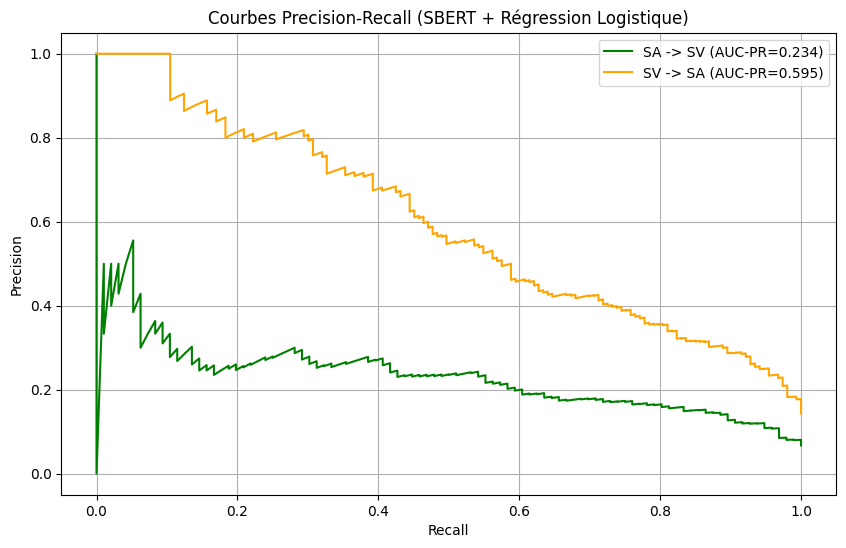

In [32]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

def plot_pr_curve(y_true, y_scores, label, color):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    auc_pr = average_precision_score(y_true, y_scores)
    plt.plot(recall, precision, label=f"{label} (AUC-PR={auc_pr:.3f})", color=color)

# === Entraîné sur SA, testé sur SV ===
model.fit(X_train_sa, y_train_sa)
y_scores_sv = model.predict_proba(X_test_sv)[:, 1]  # proba d’être VS
auc_sv = average_precision_score(y_test_sv, y_scores_sv)

# === Entraîné sur SV, testé sur SA ===
model.fit(X_train_sv, y_train_sv)
y_scores_sa = model.predict_proba(X_test_sa)[:, 1]
auc_sa = average_precision_score(y_test_sa, y_scores_sa)

# === Tracer les deux courbes ===
plt.figure(figsize=(10, 6))
plot_pr_curve(y_test_sv, y_scores_sv, "SA -> SV", color="green")
plot_pr_curve(y_test_sa, y_scores_sa, "SV -> SA", color="orange")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Courbes Precision-Recall (SBERT + Régression Logistique)")
plt.legend()
plt.grid(True)
plt.show()


### Commentaire: 
La courbe montre qu'en fait le modèle n'arrive pas à bien distinguer la classe VS qui est minoritaire ici pour les deux cas, quoi que entrainer avec les données de la thématique SV et puis tester avec les données de la thématique SA donne un meilleur score AUC-PR 

### Conclusion
Naive Bayes semble ne pas bien performer mais Regression logistique semble montrer de bonnes performances avec train = SA et test = SV

Dans la suite nous reprenons avec le modèle de mélange, sans distinction de thématique 

### Essayons de voir la vectorisation avec SBERT et la classification avec la regression logistique cette fois avec les données séparées sans distinction de thématique : Modèle de mélange 

W0814 11:50:29.072000 5428 torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


Encodage SBERT (all-MiniLM-L6-v2)...


C:\Users\stginrae.AFRIQUE-TP02\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\stginrae.AFRIQUE-TP02\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(



=== Rapport de classification — VAL SBERT + RL===
              precision    recall  f1-score   support

         NVS       0.96      0.96      0.96       470
          VS       0.65      0.60      0.62        52

    accuracy                           0.93       522
   macro avg       0.80      0.78      0.79       522
weighted avg       0.92      0.93      0.93       522



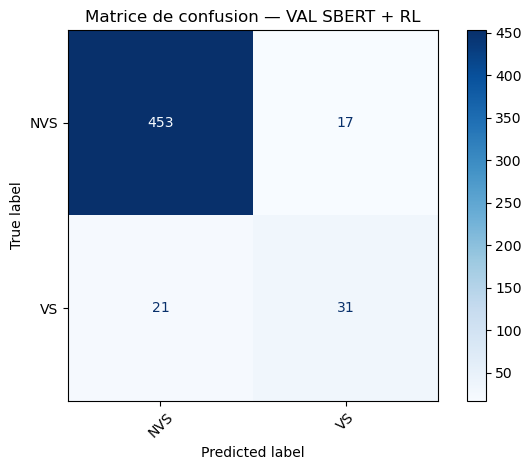


=== Rapport de classification — TEST SBERT + RL===
              precision    recall  f1-score   support

         NVS       0.96      0.97      0.96       202
          VS       0.70      0.61      0.65        23

    accuracy                           0.93       225
   macro avg       0.83      0.79      0.81       225
weighted avg       0.93      0.93      0.93       225



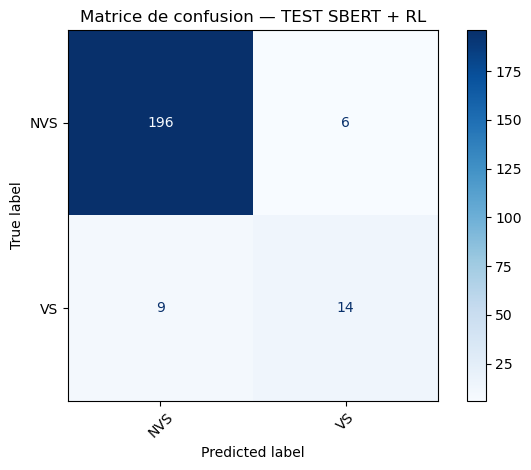

'""\n# --- 7) Sauvegardes ---\nimport joblib, os\nos.makedirs("models_sbert_lr", exist_ok=True)\njoblib.dump(scaler, "models_sbert_lr/scaler.joblib")\njoblib.dump(clf,    "models_sbert_lr/logreg.joblib")\n# Pour réutiliser SBERT en inference, on rechargera SentenceTransformer("all-MiniLM-L6-v2")\nprint("\nModèles sauvegardés dans models_sbert_lr/")\n'

In [2]:
# =========================
# SBERT + LogisticRegression avec splits par index
# =========================
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

SEED = 42

# --- 0) Splits : chargement des index ---
idx_train = np.load("splits_idx_train.npy")
idx_val   = np.load("splits_idx_val.npy")
idx_test  = np.load("splits_idx_test.npy")

# --- 1) Données ---
TEXT_COL = "text"          # "text" = brut recommandé ; nous mettrons "text_clean" pour comparer
X_all = data[TEXT_COL].astype(str).to_numpy()
y_all = data["type_article"].to_numpy()

# --- 2) Appliquer les splits par indices ---
X_train_texts, X_val_texts, X_test_texts = X_all[idx_train], X_all[idx_val], X_all[idx_test]
y_train,       y_val,       y_test       = y_all[idx_train], y_all[idx_val], y_all[idx_test]

# --- 3) SBERT Encoding ---
print("Encodage SBERT (all-MiniLM-L6-v2)...")
sbert = SentenceTransformer("all-MiniLM-L6-v2")
X_train_vec = sbert.encode(X_train_texts.tolist(), show_progress_bar=True, convert_to_numpy=True, batch_size=64)
X_val_vec   = sbert.encode(X_val_texts.tolist(),   show_progress_bar=True, convert_to_numpy=True, batch_size=64)
X_test_vec  = sbert.encode(X_test_texts.tolist(),  show_progress_bar=True, convert_to_numpy=True, batch_size=64)

# --- 4) Standardisation (fit sur TRAIN uniquement) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_vec)
X_val_scaled   = scaler.transform(X_val_vec)
X_test_scaled  = scaler.transform(X_test_vec)

# --- 5) Régression logistique  ---
# Nous avons plusieurs classes donc on reste avec "multinomial"
clf = LogisticRegression(
    max_iter=1000, solver="lbfgs", random_state=SEED,
    multi_class="multinomial", n_jobs=None
)
clf.fit(X_train_scaled, y_train)

# --- 6) Évaluations ---
def _eval(split_name, Xs, ys, labels_order):
    y_pred = clf.predict(Xs)
    print(f"\n=== Rapport de classification — {split_name} SBERT + RL===")
    print(classification_report(ys, y_pred, labels=labels_order))
    cm = confusion_matrix(ys, y_pred, labels=labels_order)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_order)
    disp.plot(cmap="Blues")
    plt.title(f"Matrice de confusion — {split_name} SBERT + RL")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

labels_order = np.unique(y_all)
_eval("VAL",  X_val_scaled,  y_val,  labels_order)
_eval("TEST", X_test_scaled, y_test, labels_order)


"""""
# --- 7) Sauvegardes ---
import joblib, os
os.makedirs("models_sbert_lr", exist_ok=True)
joblib.dump(scaler, "models_sbert_lr/scaler.joblib")
joblib.dump(clf,    "models_sbert_lr/logreg.joblib")
# Pour réutiliser SBERT en inference, on rechargera SentenceTransformer("all-MiniLM-L6-v2")
print("\nModèles sauvegardés dans models_sbert_lr/")
"""


### Commentaire: 

Le rappel de la classe minoritaire semble s'améliorer 

### Appliquons des tests avec des courtes phrases 

1. Sur les textes brutes 

In [14]:
test_phrases = [
    "Veterinarians notified authorities about an unexplained ailment affecting goats near Sanislau; the first cases were identified yesterday and the origin remains unknown.",
    "In Florida, health officials are investigating an outbreak of a mysterious disease in dogs; additional cases were found and the source has not been determined.",
    "The municipality unveiled a new public library and expanded bus routes after a community vote, focusing on transport and education plans.",
    "A local tech group hosted a robotics workshop at the university, featuring demonstrations, internships, and a student hackathon."
]

# Encodage + scaling
X_new_vec = sbert.encode(test_phrases, show_progress_bar=False, convert_to_numpy=True)
X_new_scaled = scaler.transform(X_new_vec)

# Prédictions
y_new_pred = clf.predict(X_new_scaled)
if hasattr(clf, "predict_proba"):
    y_new_proba = clf.predict_proba(X_new_scaled)
    for i, sent in enumerate(test_phrases):
        print(f"\nText: {sent}\nPred: {y_new_pred[i]}\nProba: {dict(zip(clf.classes_, y_new_proba[i].round(4)))}")
else:
    for i, sent in enumerate(test_phrases):
        print(f"\nText: {sent}\nPred: {y_new_pred[i]}")



Text: Veterinarians notified authorities about an unexplained ailment affecting goats near Sanislau; the first cases were identified yesterday and the origin remains unknown.
Pred: VS
Proba: {'NVS': 0.0694, 'VS': 0.9306}

Text: In Florida, health officials are investigating an outbreak of a mysterious disease in dogs; additional cases were found and the source has not been determined.
Pred: VS
Proba: {'NVS': 0.0, 'VS': 1.0}

Text: The municipality unveiled a new public library and expanded bus routes after a community vote, focusing on transport and education plans.
Pred: NVS
Proba: {'NVS': 1.0, 'VS': 0.0}

Text: A local tech group hosted a robotics workshop at the university, featuring demonstrations, internships, and a student hackathon.
Pred: NVS
Proba: {'NVS': 1.0, 'VS': 0.0}


### Calcul de l'AUC-PR et représentation des courbes 

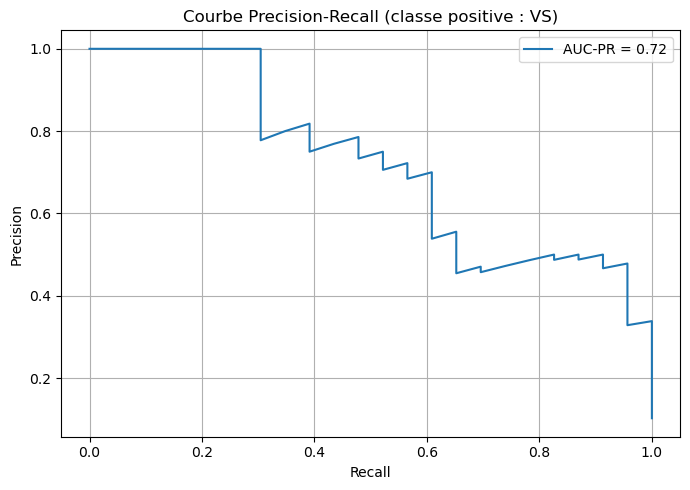

In [3]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt


# On choisit la probabilité de la classe positive (ici "VS")
# Donc un modèle parfait classerait tous les VS en haut et tous les NVS en bas pour qu'on puisse avoir une bonne courbe
positive_class = clf.classes_[1]  # Par convention, prendre la classe positive
y_score = clf.predict_proba(X_test_scaled)[:, 1]  # Score pour la classe positive

# Binariser les vraies classes : 1 si positive_class, 0 sinon
y_true_bin = (y_test == positive_class).astype(int)

# Courbe Precision-Recall
precision, recall, _ = precision_recall_curve(y_true_bin, y_score)
auc_pr = average_precision_score(y_true_bin, y_score)

# Tracer la courbe
plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f"AUC-PR = {auc_pr:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Courbe Precision-Recall (classe positive : {positive_class})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Appliquons SBERT + XGBOOST

Classes: ['NVS', 'VS']
Encodage SBERT (all-MiniLM-L6-v2)...


C:\Users\stginrae.AFRIQUE-TP02\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

[0]	train-logloss:0.30668	val-logloss:0.31427
[50]	train-logloss:0.06448	val-logloss:0.18539
[100]	train-logloss:0.02727	val-logloss:0.17724
[150]	train-logloss:0.01518	val-logloss:0.17596
[165]	train-logloss:0.01327	val-logloss:0.17589

=== Rapport de classification — VAL SBERT + XG-BOOST===
              precision    recall  f1-score   support

           0       0.94      1.00      0.96       470
           1       0.91      0.38      0.54        52

    accuracy                           0.93       522
   macro avg       0.92      0.69      0.75       522
weighted avg       0.93      0.93      0.92       522



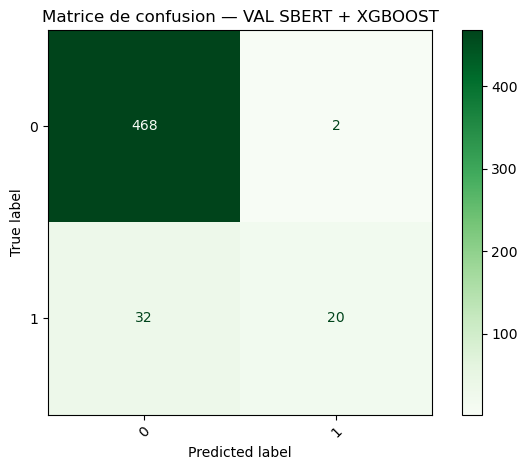


=== Rapport de classification — TEST SBERT + XG-BOOST===
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       202
           1       0.91      0.43      0.59        23

    accuracy                           0.94       225
   macro avg       0.92      0.71      0.78       225
weighted avg       0.94      0.94      0.93       225



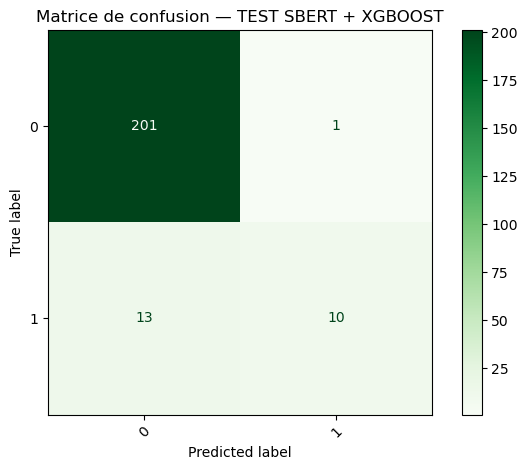

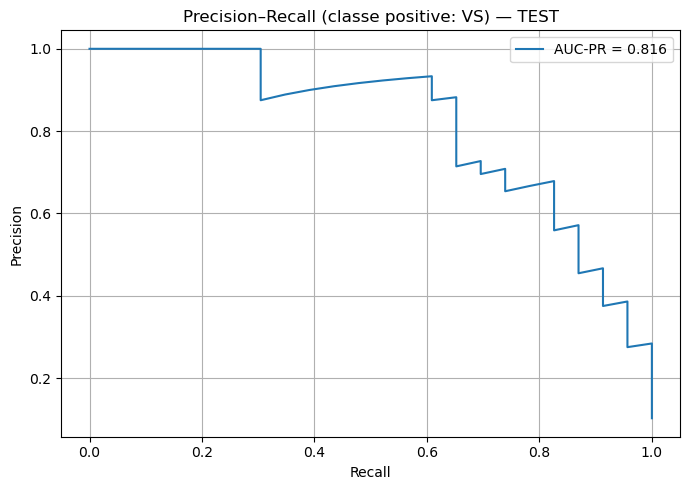

'""\n# Sauvegardes\nimport joblib, os\nos.makedirs("models_sbert_xgb", exist_ok=True)\njoblib.dump(scaler,   "models_sbert_xgb/scaler.joblib")\njoblib.dump(le,       "models_sbert_xgb/label_encoder.joblib")\nbst.save_model("models_sbert_xgb/xgb_booster.json")\n'

In [9]:
# =========================
# SBERT + XGBoost avec splits par index (VAL pour early stopping)
# =========================
import os, numpy as np, matplotlib.pyplot as plt, joblib
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             precision_recall_curve, average_precision_score)
import xgboost as xgb
from xgboost.callback import EarlyStopping

SEED = 42

# --- 0) Chargement des index sauvegardés ---
idx_train = np.load("splits_idx_train.npy")
idx_val   = np.load("splits_idx_val.npy")
idx_test  = np.load("splits_idx_test.npy")

# --- 1) Données ---
# nous pouvons choisir la colonne texte à utiliser : "text" (brut, recommandé avec SBERT) ou "text_clean" (pour une comparaison)
TEXT_COL = "text"  # changer en "text_clean" pour comparaison 
X_all = data[TEXT_COL].astype(str).to_numpy()
y_all = data["type_article"].to_numpy()

# Encodage labels (ex: ["NVS","VS"])
le = LabelEncoder()
y_enc = le.fit_transform(y_all)
classes = list(le.classes_)
print("Classes:", classes)

# --- 2) Appliquer les splits ---
X_train_texts, X_val_texts, X_test_texts = X_all[idx_train], X_all[idx_val], X_all[idx_test]
y_train,       y_val,       y_test       = y_enc[idx_train], y_enc[idx_val], y_enc[idx_test]

# --- 3) SBERT embeddings ---
print("Encodage SBERT (all-MiniLM-L6-v2)...")
sbert = SentenceTransformer("all-MiniLM-L6-v2")
X_train_vec = sbert.encode(X_train_texts.tolist(), show_progress_bar=True, batch_size=64, convert_to_numpy=True)
X_val_vec   = sbert.encode(X_val_texts.tolist(),   show_progress_bar=True, batch_size=64, convert_to_numpy=True)
X_test_vec  = sbert.encode(X_test_texts.tolist(),  show_progress_bar=True, batch_size=64, convert_to_numpy=True)

# --- 4) Standardisation (fit sur TRAIN uniquement) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_vec)
X_val_scaled   = scaler.transform(X_val_vec)
X_test_scaled  = scaler.transform(X_test_vec)

# --- 5) XGBoost : entraînement avec early stopping (API native) ---
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dval   = xgb.DMatrix(X_val_scaled,   label=y_val)
dtest  = xgb.DMatrix(X_test_scaled,  label=y_test)

params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "eta": 0.05,              # = learning_rate
    "max_depth": 5,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": SEED
}

watchlist = [(dtrain, "train"), (dval, "val")]
bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=watchlist,
    early_stopping_rounds=50,
    verbose_eval=50
)

# --- 6) Évaluations ---
def _predict_scores(bst, dmat):
    # Version-safe: utilise best_iteration si dispo, sinon fallback
    if hasattr(bst, "best_iteration") and bst.best_iteration is not None:
        try:
            return bst.predict(dmat, iteration_range=(0, bst.best_iteration + 1))
        except TypeError:
            # Anciennes versions: ntree_limit
            ntree_limit = getattr(bst, "best_ntree_limit", bst.best_iteration + 1)
            return bst.predict(dmat, ntree_limit=ntree_limit)
    else:
        return bst.predict(dmat)

def evaluate_split(name, dmat, ys, labels_order):
    y_score = _predict_scores(bst, dmat)
    y_pred = (y_score >= 0.5).astype(int)
    print(f"\n=== Rapport de classification — {name} SBERT + XG-BOOST===")
    from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
    print(classification_report(ys, y_pred, labels=labels_order, target_names=[str(c) for c in labels_order]))
    cm = confusion_matrix(ys, y_pred, labels=labels_order)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(c) for c in labels_order]).plot(cmap="Greens")
    import matplotlib.pyplot as plt
    plt.title(f"Matrice de confusion — {name} SBERT + XGBOOST")
    plt.xticks(rotation=45); plt.tight_layout(); plt.show()

labels_order = np.unique(y_enc)
evaluate_split("VAL",  dval,  y_val,  labels_order)
evaluate_split("TEST", dtest, y_test, labels_order)

# --- 7) Courbe PR / AUC-PR sur TEST ---
classes = list(le.classes_)
pos_idx = classes.index("VS") if "VS" in classes and len(classes) > 1 else 1 if len(classes) > 1 else 0
y_score = _predict_scores(bst, dtest)
y_true_bin = (y_test == pos_idx).astype(int)

from sklearn.metrics import precision_recall_curve, average_precision_score
precision, recall, _ = precision_recall_curve(y_true_bin, y_score)
auc_pr = average_precision_score(y_true_bin, y_score)

import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
plt.plot(recall, precision, label=f"AUC-PR = {auc_pr:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"Precision–Recall (classe positive: {classes[pos_idx]}) — TEST")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


"""""
# Sauvegardes
import joblib, os
os.makedirs("models_sbert_xgb", exist_ok=True)
joblib.dump(scaler,   "models_sbert_xgb/scaler.joblib")
joblib.dump(le,       "models_sbert_xgb/label_encoder.joblib")
bst.save_model("models_sbert_xgb/xgb_booster.json")
"""


### Tests sur 4 phrases comme avec le modèle précédent 

In [18]:
# === Phrases de test (2 VS, 2 NVS) ===
test_phrases = [
    "Authorities reported an outbreak of a mysterious disease affecting cattle, with new cases detected in nearby farms.",
    "Veterinarians notified the ministry about a cluster of unexplained illness in goats; several more cases were found during inspections.",
    "A national program was launched to improve cattle breeding and milk production, with training provided to local farmers.",
    "Researchers developed a new irrigation system to increase rice yields and reduce water usage in agricultural fields."
]

# 1) SBERT encode + scaling (mêmes objets que pour le train)
X_new_vec    = sbert.encode(test_phrases, show_progress_bar=False, convert_to_numpy=True)
X_new_scaled = scaler.transform(X_new_vec)

# 2) DMatrix + scores (proba de la classe '1' chez XGBoost)
dnew = xgb.DMatrix(X_new_scaled)
p1 = bst.predict(dnew)  # proba de la classe 1

# 3) Reconstruire proba de chaque classe (binaire)
p0 = 1.0 - p1

# 4) Seuil 0.5 -> prédictions en 0/1 puis en labels d'origine
y_new_enc  = (p1 >= 0.5).astype(int)
y_new_lab  = le.classes_[y_new_enc]  # mappe 0/1 -> ['NVS','VS'] dans l'ordre appris

# 5) Affichage clair
for sent, lab, prob1, prob0 in zip(test_phrases, y_new_lab, p1, p0):
    # Dictionnaire {label: proba} dans le bon ordre
    proba_dict = {le.classes_[0]: float(prob0), le.classes_[1]: float(prob1)}
    print(f"\nText: {sent}\nPred: {lab}\nProba: { {k: round(v,4) for k,v in proba_dict.items()} }")



Text: Authorities reported an outbreak of a mysterious disease affecting cattle, with new cases detected in nearby farms.
Pred: NVS
Proba: {'NVS': 0.9983, 'VS': 0.0017}

Text: Veterinarians notified the ministry about a cluster of unexplained illness in goats; several more cases were found during inspections.
Pred: NVS
Proba: {'NVS': 0.9984, 'VS': 0.0016}

Text: A national program was launched to improve cattle breeding and milk production, with training provided to local farmers.
Pred: NVS
Proba: {'NVS': 0.9991, 'VS': 0.0009}

Text: Researchers developed a new irrigation system to increase rice yields and reduce water usage in agricultural fields.
Pred: NVS
Proba: {'NVS': 0.9988, 'VS': 0.0012}


### Appliquons SBERT et MLP avec PyTorch qui possède la même structure 

Classes: ['NVS', 'VS']
Encodage SBERT (all-MiniLM-L6-v2)...


C:\Users\stginrae.AFRIQUE-TP02\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Entraînement MLP...
Epoch 01 | train_loss=0.4719 | val_loss=0.3265
Epoch 02 | train_loss=0.2276 | val_loss=0.2560
Epoch 03 | train_loss=0.1212 | val_loss=0.3126
Epoch 04 | train_loss=0.0855 | val_loss=0.4302
Epoch 05 | train_loss=0.0447 | val_loss=0.5083
Epoch 06 | train_loss=0.0293 | val_loss=0.6606
Epoch 07 | train_loss=0.0358 | val_loss=0.8019
Epoch 08 | train_loss=0.0209 | val_loss=0.6971
Early stopping (patience=6)

=== Rapport de classification — VAL SBERT + MLP (PyTorch) ===
              precision    recall  f1-score   support

         NVS       0.98      0.91      0.94       470
          VS       0.50      0.83      0.62        52

    accuracy                           0.90       522
   macro avg       0.74      0.87      0.78       522
weighted avg       0.93      0.90      0.91       522



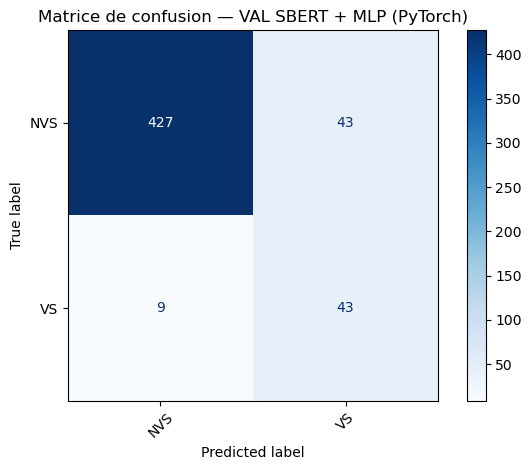


=== Rapport de classification — TEST SBERT + MLP (PyTorch) ===
              precision    recall  f1-score   support

         NVS       0.99      0.94      0.96       202
          VS       0.62      0.91      0.74        23

    accuracy                           0.93       225
   macro avg       0.80      0.92      0.85       225
weighted avg       0.95      0.93      0.94       225



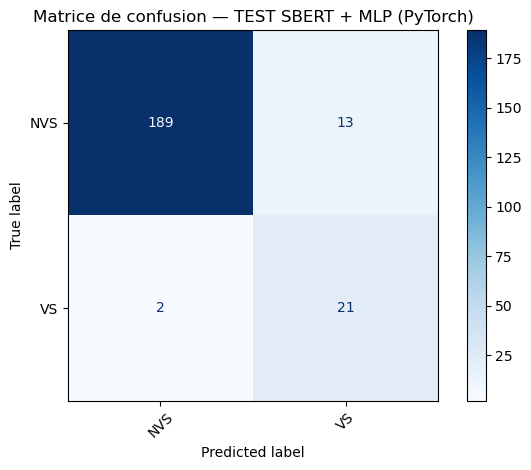

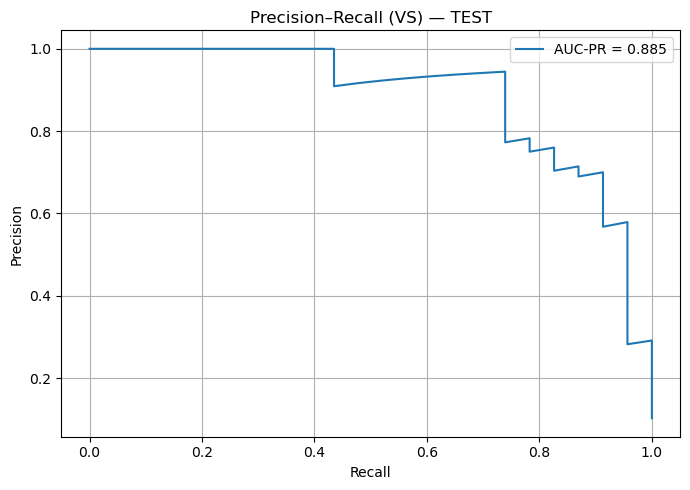

In [7]:
# =========================
# SBERT + MLP (PyTorch) avec splits par index (VAL pour early stopping)
# =========================
import os, numpy as np, matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, average_precision_score
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# --- 0) Splits sauvegardés ---
idx_train = np.load("splits_idx_train.npy")
idx_val   = np.load("splits_idx_val.npy")
idx_test  = np.load("splits_idx_test.npy")

# --- 1) Données ---
TEXT_COL = "text"  # textes bruts car SBERT a déjà son
X_all = data[TEXT_COL].astype(str).to_numpy()
y_all = data["type_article"].to_numpy()

# Encodage labels sur TOUT l'ensemble (cohérent avec les autres scripts)
label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(y_all)
classes = list(label_encoder.classes_)
print("Classes:", classes)

# --- 2) Appliquer les splits par indices ---
X_train_texts, X_val_texts, X_test_texts = X_all[idx_train], X_all[idx_val], X_all[idx_test]
y_train,       y_val,       y_test       = y_enc[idx_train], y_enc[idx_val], y_enc[idx_test]

# --- 3) SBERT embeddings ---
print("Encodage SBERT (all-MiniLM-L6-v2)...")
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")
X_train_vec = sbert_model.encode(X_train_texts.tolist(), show_progress_bar=True, convert_to_numpy=True, batch_size=64)
X_val_vec   = sbert_model.encode(X_val_texts.tolist(),   show_progress_bar=True, convert_to_numpy=True, batch_size=64)
X_test_vec  = sbert_model.encode(X_test_texts.tolist(),  show_progress_bar=True, convert_to_numpy=True, batch_size=64)

# --- 4) Standardisation (fit sur TRAIN uniquement) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_vec)
X_val_scaled   = scaler.transform(X_val_vec)
X_test_scaled  = scaler.transform(X_test_vec)

# --- 5) Tensor + DataLoader ---
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor   = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val, dtype=torch.long)

X_test_tensor  = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_tensor, y_val_tensor),     batch_size=256, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test_tensor, y_test_tensor),   batch_size=256, shuffle=False)

# --- 6) Modèle MLP ---
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes, dropout=0.1):
        super().__init__()
        h1, h2 = hidden_dims
        self.net = nn.Sequential(
            nn.Linear(input_dim, h1), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(h1, h2),        nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(h2, num_classes)
        )
    def forward(self, x):
        return self.net(x)

input_dim   = X_train_scaled.shape[1]     # 384 pour all-MiniLM-L6-v2
num_classes = len(classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# La couche d'entrée a 384 neurone, les deux couches cachées ont respectivement 128 et 64 neurones 
mlp = MLPClassifier(input_dim, hidden_dims=(128, 64), num_classes=num_classes, dropout=0.1).to(device)

# pondération : comme nous avons un déséquilibre
from sklearn.utils.class_weight import compute_class_weight
cw = compute_class_weight("balanced", classes=np.arange(num_classes), y=y_train)
class_weights = torch.tensor(cw, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(mlp.parameters(), lr=1e-3, weight_decay=1e-4)


# --- 7) Entraînement avec early stopping sur la loss VAL ---
EPOCHS = 50
patience = 6
best_val = float("inf")
best_state = None
no_improve = 0

print("Entraînement MLP...")
for epoch in range(1, EPOCHS + 1):
    # Train
    mlp.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = mlp(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

    # Val
    mlp.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = mlp(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

    # Early stopping
    if val_loss + 1e-6 < best_val:
        best_val = val_loss
        best_state = {k: v.cpu().clone() for k, v in mlp.state_dict().items()}
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"Early stopping (patience={patience})")
            break

# Charger le meilleur état
if best_state is not None:
    mlp.load_state_dict(best_state)
mlp.to(device).eval()

def _predict_loader(model, loader):
    y_pred, y_true, y_prob = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            y_prob.append(probs)
            y_pred.append(np.argmax(probs, axis=1))
            y_true.append(yb.numpy())
    return np.concatenate(y_true), np.concatenate(y_pred), np.concatenate(y_prob)

# --- 8) Évaluations ---
def evaluate_split(name, loader, label_names):
    yt, yp, yproba = _predict_loader(mlp, loader)
    print(f"\n=== Rapport de classification — {name} SBERT + MLP (PyTorch) ===")
    print(classification_report(yt, yp, target_names=label_names))
    cm = confusion_matrix(yt, yp)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names).plot(cmap="Blues")
    plt.title(f"Matrice de confusion — {name} SBERT + MLP (PyTorch)")
    plt.xticks(rotation=45); plt.tight_layout(); plt.show()
    return yt, yproba

# VAL
_ = evaluate_split("VAL",  val_loader,  classes)
# TEST
y_true_test, y_proba_test = evaluate_split("TEST", test_loader, classes)

# --- 9) Courbe PR / AUC-PR sur TEST (classe VS si présente) ---
if "VS" in classes and num_classes >= 2:
    vs_idx = classes.index("VS")
    y_true_bin = (y_true_test == vs_idx).astype(int)
    y_prob_vs  = y_proba_test[:, vs_idx]
    precision, recall, _ = precision_recall_curve(y_true_bin, y_prob_vs)
    auc_pr = average_precision_score(y_true_bin, y_prob_vs)
    plt.figure(figsize=(7, 5))
    plt.plot(recall, precision, label=f"AUC-PR = {auc_pr:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Precision–Recall (VS) — TEST")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# --- 10) (Optionnel) Sauvegardes
# torch.save(mlp.state_dict(), "models_sbert_mlp/mlp.pth")
# import joblib, os
# os.makedirs("models_sbert_mlp", exist_ok=True)
# joblib.dump(label_encoder, "models_sbert_mlp/label_encoder.joblib")
# joblib.dump(scaler,       "models_sbert_mlp/scaler.joblib")


### Commentaire:

SBERT semble donner de meilleur résultat ici et l'AUC-PR est mieux que RoBERTa et cette configuration de MLP

### Appliquons TF-IDF et XGBOOST : Modèle de mélange 

Nous utilisons les index sauvegardés 

[0]	train-logloss:0.29589	eval-logloss:0.29890
[1]	train-logloss:0.27148	eval-logloss:0.27545
[2]	train-logloss:0.25265	eval-logloss:0.25953
[3]	train-logloss:0.23572	eval-logloss:0.24434
[4]	train-logloss:0.22112	eval-logloss:0.23101
[5]	train-logloss:0.21010	eval-logloss:0.22005
[6]	train-logloss:0.19758	eval-logloss:0.20809
[7]	train-logloss:0.19030	eval-logloss:0.20184
[8]	train-logloss:0.18035	eval-logloss:0.19291
[9]	train-logloss:0.17188	eval-logloss:0.18514
[10]	train-logloss:0.16378	eval-logloss:0.17734
[11]	train-logloss:0.15611	eval-logloss:0.16951
[12]	train-logloss:0.14924	eval-logloss:0.16346
[13]	train-logloss:0.14300	eval-logloss:0.15773
[14]	train-logloss:0.13729	eval-logloss:0.15265
[15]	train-logloss:0.13150	eval-logloss:0.14775
[16]	train-logloss:0.12647	eval-logloss:0.14297
[17]	train-logloss:0.12108	eval-logloss:0.13787
[18]	train-logloss:0.11656	eval-logloss:0.13414
[19]	train-logloss:0.11265	eval-logloss:0.13025
[20]	train-logloss:0.10847	eval-logloss:0.12656
[2

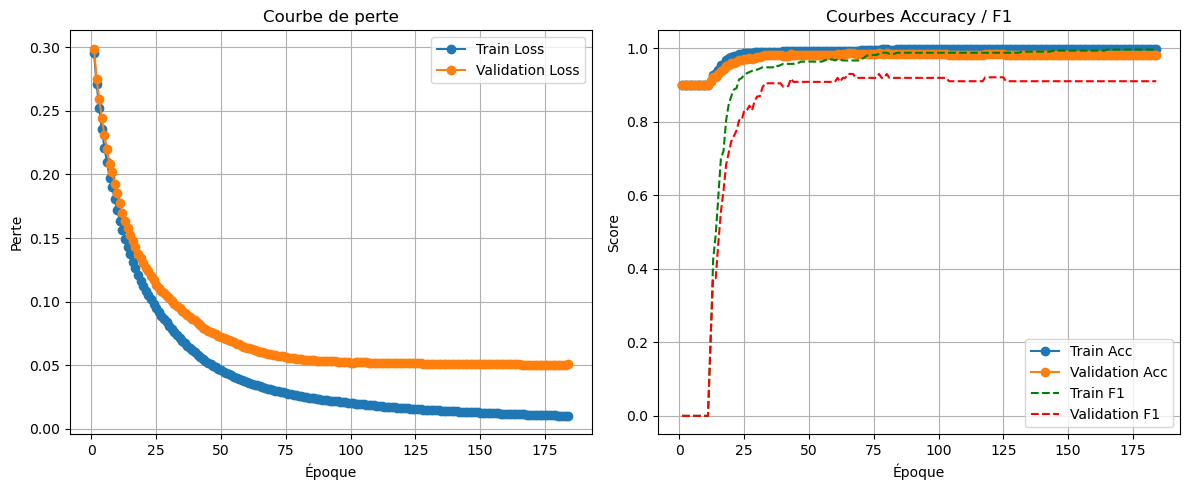

=== Rapport de classification (TF-IDF + XGBoost) sur les données de test ===
              precision    recall  f1-score   support

         NVS       0.99      1.00      0.99       202
          VS       1.00      0.87      0.93        23

    accuracy                           0.99       225
   macro avg       0.99      0.93      0.96       225
weighted avg       0.99      0.99      0.99       225



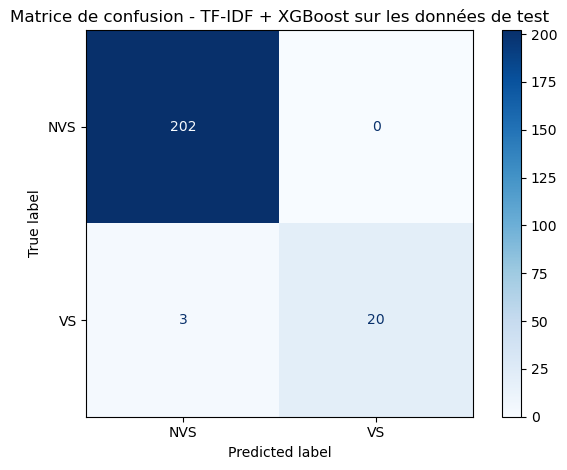

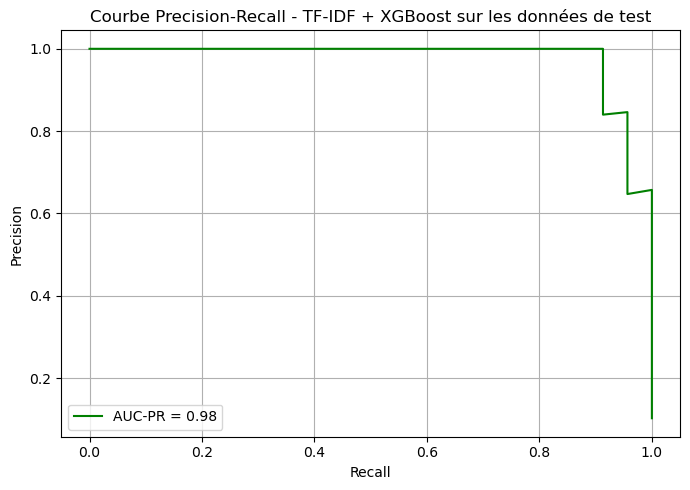

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    average_precision_score
)
import matplotlib.pyplot as plt
import xgboost as xgb
import joblib
from sklearn.metrics import accuracy_score, f1_score
import os, joblib
import numpy as np

idx_train = np.load("splits_idx_train.npy")
idx_val   = np.load("splits_idx_val.npy")
idx_test  = np.load("splits_idx_test.npy")

# === 1. Données
X = data["text_clean"].astype(str).to_numpy()
y = data["type_article"].to_numpy()

# Encodage binaire (NVS = 0, VS = 1)
le = LabelEncoder()
y_enc = le.fit_transform(y)

# === 2. Split train / temp
X_train_texts, X_val_texts, X_test_texts = X[idx_train], X[idx_val], X[idx_test]
y_train, y_val, y_test = y_enc[idx_train], y_enc[idx_val], y_enc[idx_test]



# === 4. TF-IDF Vectorisation
vec = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_vec = vec.fit_transform(X_train_texts)
X_val_vec   = vec.transform(X_val_texts)
X_test_vec  = vec.transform(X_test_texts)

# === 5. Modèle XGBoost avec early stopping


# Convertir en DMatrix, forme optimisée pour le modèle xgboost
dtrain = xgb.DMatrix(X_train_vec, label=y_train)
dval = xgb.DMatrix(X_val_vec, label=y_val)
dtest = xgb.DMatrix(X_test_vec)

# Paramètres du modèle
params = {
    "objective": "binary:logistic", # classification binaire
    "eval_metric": "logloss", # on regarde le logarithme de l'erreur 
    "max_depth": 5, # profondeur d'un arbre de la forêt
    "eta": 0.05, # taux d'apprentissage
    "subsample": 0.8, # taux d'échantillonnage 
    "colsample_bytree": 0.8,
    "seed": 42
}

# Initialisation du dictionnaire pour stocker les métriques
evals_result = {}

# Entraînement avec early stopping
watchlist = [(dtrain, "train"), (dval, "eval")]
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000, # les arbres sont ajoutés de manière itérative, maintenant si l'apprentissage n'évolue pas on ajoute plus d'arbre
    evals=watchlist,
    early_stopping_rounds=10,
    evals_result=evals_result,
    verbose_eval=True
)

# === Courbes d'apprentissage (loss, accuracy, f1) ===
train_loss = evals_result['train']['logloss']
val_loss = evals_result['eval']['logloss']

# On calcule manuellement accuracy et f1 à chaque étape
train_acc, val_acc, train_f1, val_f1 = [], [], [], []

for i in range(len(train_loss)):
    # Prédictions train et val à l'itération i
    y_train_pred = (bst.predict(dtrain, iteration_range=(0, i+1)) >= 0.5).astype(int)
    y_val_pred = (bst.predict(dval, iteration_range=(0, i+1)) >= 0.5).astype(int)

    # Accuracies
    train_acc.append(accuracy_score(y_train, y_train_pred))
    val_acc.append(accuracy_score(y_val, y_val_pred))

    # F1 scores
    train_f1.append(f1_score(y_train, y_train_pred))
    val_f1.append(f1_score(y_val, y_val_pred))


# Affichage des courbes 
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

# --- Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Train Loss", marker="o")
plt.plot(epochs, val_loss, label="Validation Loss", marker="o")
plt.xlabel("Époque")
plt.ylabel("Perte")
plt.title("Courbe de perte")
plt.legend()
plt.grid(True)

# --- Courbes Accuracy et F1
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label="Train Acc", marker="o")
plt.plot(epochs, val_acc, label="Validation Acc", marker="o")
plt.plot(epochs, train_f1, label="Train F1", linestyle="--", color="green")
plt.plot(epochs, val_f1, label="Validation F1", linestyle="--", color="red")
plt.xlabel("Époque")
plt.ylabel("Score")
plt.title("Courbes Accuracy / F1")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



# Prédiction sur les données de test
y_scores = bst.predict(dtest)
y_pred = (y_scores >= 0.5).astype(int)


os.makedirs("models", exist_ok=True)  # crée le dossier si absent

bst.save_model("models/sbert_xgb.json")  # ou best_modele_melange.json si tu veux
joblib.dump(le, "models/label_encoder.pkl")


# Sauvegarde du modèle 
bst.save_model("models/best_modele_melange.json")

# Sauvegarde du vectorizer 

joblib.dump(vec, "models/vectorizer_melange.pkl")

# Rapport
print("=== Rapport de classification (TF-IDF + XGBoost) sur les données de test ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues")
plt.title("Matrice de confusion - TF-IDF + XGBoost sur les données de test")
plt.tight_layout()
plt.show()

# Courbe AUC-PR
precision, recall, _ = precision_recall_curve(y_test, y_scores)
auc_pr = average_precision_score(y_test, y_scores)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f"AUC-PR = {auc_pr:.2f}", color="green")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Courbe Precision-Recall - TF-IDF + XGBoost sur les données de test")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Commentaire: 

C'est le meilleur modèle depuis que nous faisons des expérimentations. Nous l'avons gardé pour faire encore quelques expérimentations (données avec et sans noms de maladie) dans le notebook *classification.ipynb*

### Voyons voir les mots que ce modèle utilise pour classer un article comme VS

In [38]:
# Récupérer les scores d'importance des features (TF-IDF)
importance_scores = bst.get_score(importance_type='weight')  # ou 'gain' pour l'impact moyen sur la perte

# Map features index to their names
feature_names = vec.get_feature_names_out()

# Convertir les clés de type 'f123' -> index entier
feature_importances = {
    feature_names[int(k[1:])]: v for k, v in importance_scores.items()
}

# Trier par importance décroissante
sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Afficher les 20 mots les plus importants
print("Top 20 mots les plus influents (poids) :")
for word, score in sorted_features[:20]:
    print(f"{word} : {score}")


Top 20 mots les plus influents (poids) :
mysterious : 105.0
disease : 93.0
unknown : 58.0
mystery : 45.0
said : 25.0
block : 24.0
could : 21.0
target : 20.0
may : 18.0
need : 15.0
using : 15.0
pest : 14.0
certain : 13.0
illness : 13.0
group : 12.0
http : 12.0
press : 11.0
reported : 11.0
together : 11.0
research : 10.0


### Rechargeons ce modèle et appliquons certains tests de prédiction avec des courts articles 

Il faudra aussi nettoyer ces courts articles car nous avons entrainer le modèle avec les données nettoyées 

#### Fonction de nettoyage des textes que nous avons appliquée pour former la colonne "text_clean"

In [ ]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import punctuation

# Initialisation
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
custom_stopwords = {'et', 'al'} # Les expressions que nous avons retrouvé en grande quantité lors de nos expérimentations et nous avons décidé de ne pas les conserver 


def nettoyer_texte(texte):
    """
    Nettoie un texte brut :
    2. Tokenisation
    3. Nettoyage caractères spéciaux
    4. Suppression stopwords, ponctuation, custom_stopwords
    5. Lemmatisation
    """
    
    # Étape 2 : tokenisation
    tokens = word_tokenize(texte)

    # Étape 3-6 : nettoyage
    tokens_nettoyes = []
    for token in tokens:
        token = token.lower()
        token = re.sub(r'\s+', '', token)
        token = re.sub(r'[^a-zàâçéèêëîïôûùüÿñæœ]', '', token)

        if (
            token
            and token not in stop_words
            and token not in punctuation
            and token not in custom_stopwords
        ):
            token = lemmatizer.lemmatize(token)
            tokens_nettoyes.append(token)

    return ' '.join(tokens_nettoyes)


In [17]:
import xgboost as xgb
import joblib


# === 1. Recharger le modèle XGBoost, le vectorizer et le label encoder
bst = xgb.Booster()
bst.load_model("models/best_modele_melange.json")

vectorizer = joblib.load("models/vectorizer_melange.pkl")


# === 2. Textes de test
phrases_test = [
    "Authorities reported an outbreak of a mysterious disease affecting cattle, with new cases detected in nearby farms.",
    "Veterinarians notified the ministry about a cluster of unexplained illness in goats; several more cases were found during inspections.",
    "A national program was launched to improve cattle breeding and milk production, with training provided to local farmers.",
    "Researchers developed a new irrigation system to increase rice yields and reduce water usage in agricultural fields."
]

# === 3. TF-IDF vectorisation
X_test_vec = vectorizer.transform(phrases_test)

# === 4. Conversion en DMatrix
dtest = xgb.DMatrix(X_test_vec)

# === 5. Prédictions
y_scores = bst.predict(dtest)
y_pred = (y_scores >= 0.5).astype(int)
y_labels = le.inverse_transform(y_pred)

# === 6. Affichage
for phrase, label, score in zip(phrases_test, y_labels, y_scores):
    print("Texte :", phrase)
    print("-> Classe prédite :", label)
    print(f"-> Score VS : {score:.4f}, NVS : {1 - score:.4f}")
    print("-" * 60)


Texte : Authorities reported an outbreak of a mysterious disease affecting cattle, with new cases detected in nearby farms.
-> Classe prédite : VS
-> Score VS : 0.9854, NVS : 0.0146
------------------------------------------------------------
Texte : Veterinarians notified the ministry about a cluster of unexplained illness in goats; several more cases were found during inspections.
-> Classe prédite : NVS
-> Score VS : 0.0042, NVS : 0.9958
------------------------------------------------------------
Texte : A national program was launched to improve cattle breeding and milk production, with training provided to local farmers.
-> Classe prédite : NVS
-> Score VS : 0.0009, NVS : 0.9991
------------------------------------------------------------
Texte : Researchers developed a new irrigation system to increase rice yields and reduce water usage in agricultural fields.
-> Classe prédite : NVS
-> Score VS : 0.0005, NVS : 0.9995
------------------------------------------------------------


### Commentaire: 

Nous constatons que ce modèle n'arrive pas à capter la semantique car le premier article parle bien de veille syndromique sauf qu'il utilise les synonymes des expressions que ce modèle est capable de capter comme étant VS. Ces expressions combinées dans la troisième phrase permet à ce modèle de classer fortement l'article comme étant de type VS   

C'est la raison pour laquelle nous avons pensé à faire du fine-tuning dans la suite: voir le notebook *fine_tuning_classification_2.ipynb*

Mais nous avons encore un notebook dans lequel nous appliquons TF-IDF + XGBOOST sur des articles avec et sans noms de maladie afin de mieux comprendre 